Dataset organized kindly by user Mourad. https://www.kaggle.com/msheriey/104-flowers-garden-of-eden

# import

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import Xception, DenseNet201
from tensorflow.keras.callbacks import LearningRateScheduler
import random
from PIL import Image
import shutil

# global variables

In [4]:
# image size options: 192, 224, 311, 512
IMAGE_DIMENSION = 192
VECTOR_LEN = IMAGE_DIMENSION**2
NUM_CLASS = 104

TRAIN_DIR = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/train'
VAL_DIR = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/val'
TEST_DIR = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/test'

BATCH_SIZE = 10
TRAIN_BATCH_SIZE = BATCH_SIZE
VAL_BATCH_SIZE = BATCH_SIZE
TEST_BATCH_SIZE = 32

# generate datasets

In [3]:
# train_img, train_lb = next(generate_train_dataset()) # x_train, y_train
# val_img, val_lb = next(generate_val_dataset()) # x_test, y_test
# test_img, test_lb = next(generate_test_dataset())

In [4]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [65]:
train_img, train_lb = next(train_generator)
val_img, val_lb = next(val_generator)
test_img, test_lb = next(test_generator)

# explore data

In [66]:
train_img.shape, train_lb.shape

((10, 192, 192, 3), (10, 104))

In [67]:
train_lb[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

# preprocessing

In [ ]:
train_img.shape, train_lb.shape

In [ ]:
print(np.shape(train_img))
print(np.shape(train_lb))
print(np.shape(val_img))
print(np.shape(val_lb))

In [ ]:
train_img_unrow = train_img.reshape(TRAIN_BATCH_SIZE, -1).T
np.shape(train_img_unrow)

In [ ]:
val_img_unrow = val_img.reshape(VAL_BATCH_SIZE, -1).T
np.shape(val_img_unrow)

# base model cnn

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model.add(layers.Flatten())        
# possibly more layers here

model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model.fit_generator(train_generator, epochs=5, validation_data=val_generator)


In [ ]:
model.fit(train_generator, epochs=5, validation_data=val_generator, use_multiprocessing=False)

### High train accuracy and low val accuracy. Adding more layers and normalizing to bring them closer

In [ ]:
# Build the model with multiple hidden layers
model_2 = models.Sequential()

model_2.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model_2.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_2.add(layers.Flatten())        
# possibly more layers here
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION,)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(NUM_CLASS)) # output layer
model_2.add(layers.Activation('sigmoid'))

In [ ]:
model_2.summary()

In [ ]:
# Define an optimizer, cost lost function, and scoring metric
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_2.fit(train_generator, epochs=5, validation_data=val_generator, use_multiprocessing=False)

### introduce transfer learning

In [ ]:
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
Xception_model.trainable = False

model_tl_1 = Sequential([
    Xception_model,
    layers.Conv2D(filters=32, 
        kernel_size=(2,2),
        strides=(1,1),
        activation='relu',
        padding = 'same',
        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
        data_format = 'channels_last'),
    layers.Flatten(),
    Dense(NUM_CLASS, activation='sigmoid')
])

model_tl_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model_tl_1.fit(train_generator, epochs=5, validation_data=val_generator, use_multiprocessing=False)

### using globalaveragepooling

In [ ]:
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
Xception_model.trainable = False

model_tl_2 = Sequential([
    Xception_model,
    GlobalAveragePooling2D(),
    layers.Flatten(),
    model_4.add(layers.Dropout(0.2, input_shape=(IMAGE_DIMENSION,)))
    Dense(NUM_CLASS, activation='sigmoid')
])

model_tl_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model_tl_2.fit(train_generator, epochs=50, validation_data=val_generator, use_multiprocessing=False)

### even more basic model

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=5, validation_data=val_generator, use_multiprocessing=False)

### overfitting, going to introduce some data augmentation here

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=5, validation_data=val_generator, use_multiprocessing=False)

### attempt to reduce overfitting (dropout) and more epochs (25) to run overnight

In [11]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=15,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5]
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 95, 95, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        16448     
_________________________________________________________________
flatten_1 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 135424)           

In [13]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=25,
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 812/1145 [====================>.........] - ETA: 26s - loss: 4.1548 - accuracy: 0.0811

KeyboardInterrupt: 

# much better accuracy

### introduce learning rate

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=25,
          validation_data=val_generator, callbacks=lr_callback, use_multiprocessing=False)

### reintroduce transfer learning

In [6]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [7]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [12]:
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
Xception_model.trainable = False

model = Sequential([
    Xception_model,
    GlobalAveragePooling2D(),
    layers.Flatten(),
#    Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)),
#    Dense(64, activation='relu'),
    Dense(NUM_CLASS, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=20, 
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 3.5389 - accuracy: 0.2547WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x17fbcd1f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

KeyboardInterrupt: 

### attempt to remove flattening to see how that affects the model. also introduce dropout

In [14]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [15]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [16]:
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
Xception_model.trainable = False

model = Sequential([
    Xception_model,
    GlobalAveragePooling2D(),
#    layers.Flatten(),
    Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)),
#    Dense(64, activation='relu'),
    Dense(NUM_CLASS, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


In [17]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=20, 
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 3.7230 - accuracy: 0.2144WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x355b96430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

KeyboardInterrupt: 

### shuffle for validation is turned off

In [18]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [19]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=False
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [20]:
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
Xception_model.trainable = False

model = Sequential([
    Xception_model,
    GlobalAveragePooling2D(),
#    layers.Flatten(),
    Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)),
#    Dense(64, activation='relu'),
    Dense(NUM_CLASS, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


In [21]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=20, 
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 3.7176 - accuracy: 0.2157WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2c7eaff70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

KeyboardInterrupt: 

### shuffle is turned back on. going to a model with densenet201 instead

In [27]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [28]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [31]:
DenseNet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
DenseNet_model.trainable = False

model = Sequential([
    DenseNet_model,
    GlobalAveragePooling2D(),
#    layers.Flatten(),
    Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)),
#    Dense(64, activation='relu'),
    Dense(NUM_CLASS, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=20, 
          validation_data=val_generator, use_multiprocessing=False)

### WEIRD ATTEMPT HERE

In [8]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [9]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [10]:
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3])
Xception_model.trainable = False

model = Sequential([
    Xception_model,
    GlobalAveragePooling2D(),
    layers.Flatten(),
#    Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)),
#    Dense(64, activation='relu'),
    Dense(NUM_CLASS, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

ImportError: `load_weights` requires h5py when loading weights from HDF5.

In [13]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=20, 
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 3.5389 - accuracy: 0.2547WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x17fbcd1f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

KeyboardInterrupt: 

### try a different pretrained model. ENet B7

### ensemble for more trained images

### removal of transfer learning

In [14]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [15]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.70, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Conv2D(4, (3,2), activation='relu'))
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 94, 94, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 45, 46, 4)        

In [16]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=25,
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 4.2987 - accuracy: 0.0631WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x17258d160> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

### replace flatten with global average pooling

In [25]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2,
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [26]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.70, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Conv2D(4, (3,2), activation='relu'))
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 94, 94, 16)        4624      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 46, 4)        

In [27]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=25,
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 4.1093 - accuracy: 0.0680WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2fe782550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

### rerunning this in hopes to get best performing model again

In [28]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2,
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [29]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 95, 95, 64)        8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 46, 46, 64)        16448     
_________________________________________________________________
flatten_3 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 135424)           

In [30]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=25,
          validation_data=val_generator, use_multiprocessing=False)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 4.1307 - accuracy: 0.0758WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2cf9f4d30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

### running above with learning rate

In [31]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [32]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [33]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 95, 95, 64)        8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 46, 46, 64)        16448     
_________________________________________________________________
flatten_4 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 135424)           

In [34]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=25,
          validation_data=val_generator, callbacks=lr_callback, use_multiprocessing=False)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 4.0301 - accuracy: 0.0905WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2fefb1ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

### increasing number of epochs for the sake of it

In [35]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [36]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [37]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 95, 95, 64)        8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 46, 46, 64)        16448     
_________________________________________________________________
flatten_5 (Flatten)          (None, 135424)           

In [38]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=50,
          validation_data=val_generator, callbacks=lr_callback, use_multiprocessing=False)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 4.2746 - accuracy: 0.0681WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2cf9f4040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

Epoch 43/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.3088 - accuracy: 0.3728 - val_loss: 183.7158 - val_accuracy: 0.2170
Epoch 44/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.2849 - accuracy: 0.3732 - val_loss: 174.5177 - val_accuracy: 0.2323
Epoch 45/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.3005 - accuracy: 0.3690 - val_loss: 178.0510 - val_accuracy: 0.2181
Epoch 46/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.2708 - accuracy: 0.3800 - val_loss: 182.0894 - val_accuracy: 0.2159
Epoch 47/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.3004 - accuracy: 0.3659 - val_loss: 183.3173 - val_accuracy: 0.2164
Epoch 48/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.3126 - accuracy: 0.3767 - val_loss: 186.6792 - val_accuracy: 0.2148
Epoch 49/50
1145/1145 [==============================] - 102s 89ms/step - loss: 2.2834 - accuracy: 0

### trying to recreate the best model. reducing number of layers

In [43]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_callback = LearningRateScheduler(scheduler)

In [44]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=90,
                                     vertical_flip=True,
                                     brightness_range=[0.5,1.5],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11459 images belonging to 104 classes.
Found 3710 images belonging to 104 classes.
Found 1294 images belonging to 104 classes.


In [45]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((3,4)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5, input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 94, 94, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 23, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 45632)             0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 45632)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [46]:
model.fit(train_generator, steps_per_epoch=11459 // BATCH_SIZE, epochs=50,
          validation_data=val_generator, callbacks=lr_callback, use_multiprocessing=False)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1145/1145 [==============================] - ETA: 0s - loss: 4.0908 - accuracy: 0.0856WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x3962c1c10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

KeyboardInterrupt: 

### attempting to reduce the number of classes. removing the classes beyond three standard deviations

In [71]:
import os, os.path

In [74]:
# can delete
class_list_dir = []

for file in os.listdir(TRAIN_DIR):
    d = os.path.join(TRAIN_DIR, file)
    if os.path.isdir(d):
        class_list_dir.append(d)
        
class_list_dir

['data/jpeg-192x192/train/toad lily',
 'data/jpeg-192x192/train/love in the mist',
 'data/jpeg-192x192/train/monkshood',
 'data/jpeg-192x192/train/azalea',
 'data/jpeg-192x192/train/fritillary',
 'data/jpeg-192x192/train/silverbush',
 'data/jpeg-192x192/train/canterbury bells',
 'data/jpeg-192x192/train/stemless gentian',
 'data/jpeg-192x192/train/pink primrose',
 'data/jpeg-192x192/train/buttercup',
 'data/jpeg-192x192/train/poinsettia',
 'data/jpeg-192x192/train/desert-rose',
 'data/jpeg-192x192/train/bird of paradise',
 'data/jpeg-192x192/train/columbine',
 'data/jpeg-192x192/train/frangipani',
 'data/jpeg-192x192/train/sweet pea',
 'data/jpeg-192x192/train/siam tulip',
 'data/jpeg-192x192/train/great masterwort',
 'data/jpeg-192x192/train/hard-leaved pocket orchid',
 'data/jpeg-192x192/train/marigold',
 'data/jpeg-192x192/train/foxglove',
 'data/jpeg-192x192/train/wild pansy',
 'data/jpeg-192x192/train/windflower',
 'data/jpeg-192x192/train/daisy',
 'data/jpeg-192x192/train/tiger l

In [151]:
file_count = sum(len(files) for _, _, files in os.walk(TRAIN_DIR))
print(file_count)

11564


In [129]:
# can delete
class_count = {}

for class_folder in class_list_dir:
    file_count = sum(len(files) for _, _, files in os.walk(class_folder))
    class_count[class_folder[24:]] = file_count, class_folder

In [144]:
# can delete 
flower_count = []

for flower in list(class_count.values()):
    flower_count.append(flower[0])
    
print(flower_count)

[78, 21, 79, 124, 44, 26, 18, 32, 246, 236, 100, 29, 95, 102, 139, 19, 17, 24, 24, 113, 126, 95, 235, 381, 79, 50, 33, 19, 34, 17, 82, 707, 53, 205, 22, 17, 58, 22, 86, 238, 32, 508, 58, 46, 95, 18, 19, 126, 16, 107, 415, 151, 104, 23, 81, 29, 77, 99, 123, 38, 132, 182, 95, 84, 22, 352, 24, 670, 276, 113, 87, 27, 42, 115, 53, 101, 634, 108, 85, 33, 92, 19, 122, 25, 67, 17, 40, 96, 91, 50, 76, 16, 108, 77, 27, 87, 52, 31, 59, 119, 109, 415, 87, 156]


In [150]:
# shows the count
print(list(class_count.values())[0][0])

# shows the directory 
print(list(class_count.values())[0][1])

78
data/jpeg-192x192/train/toad lily


<BarContainer object of 104 artists>

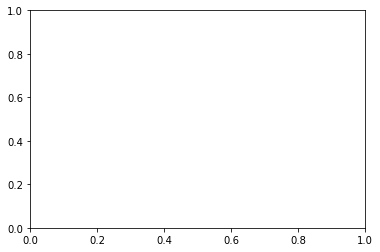

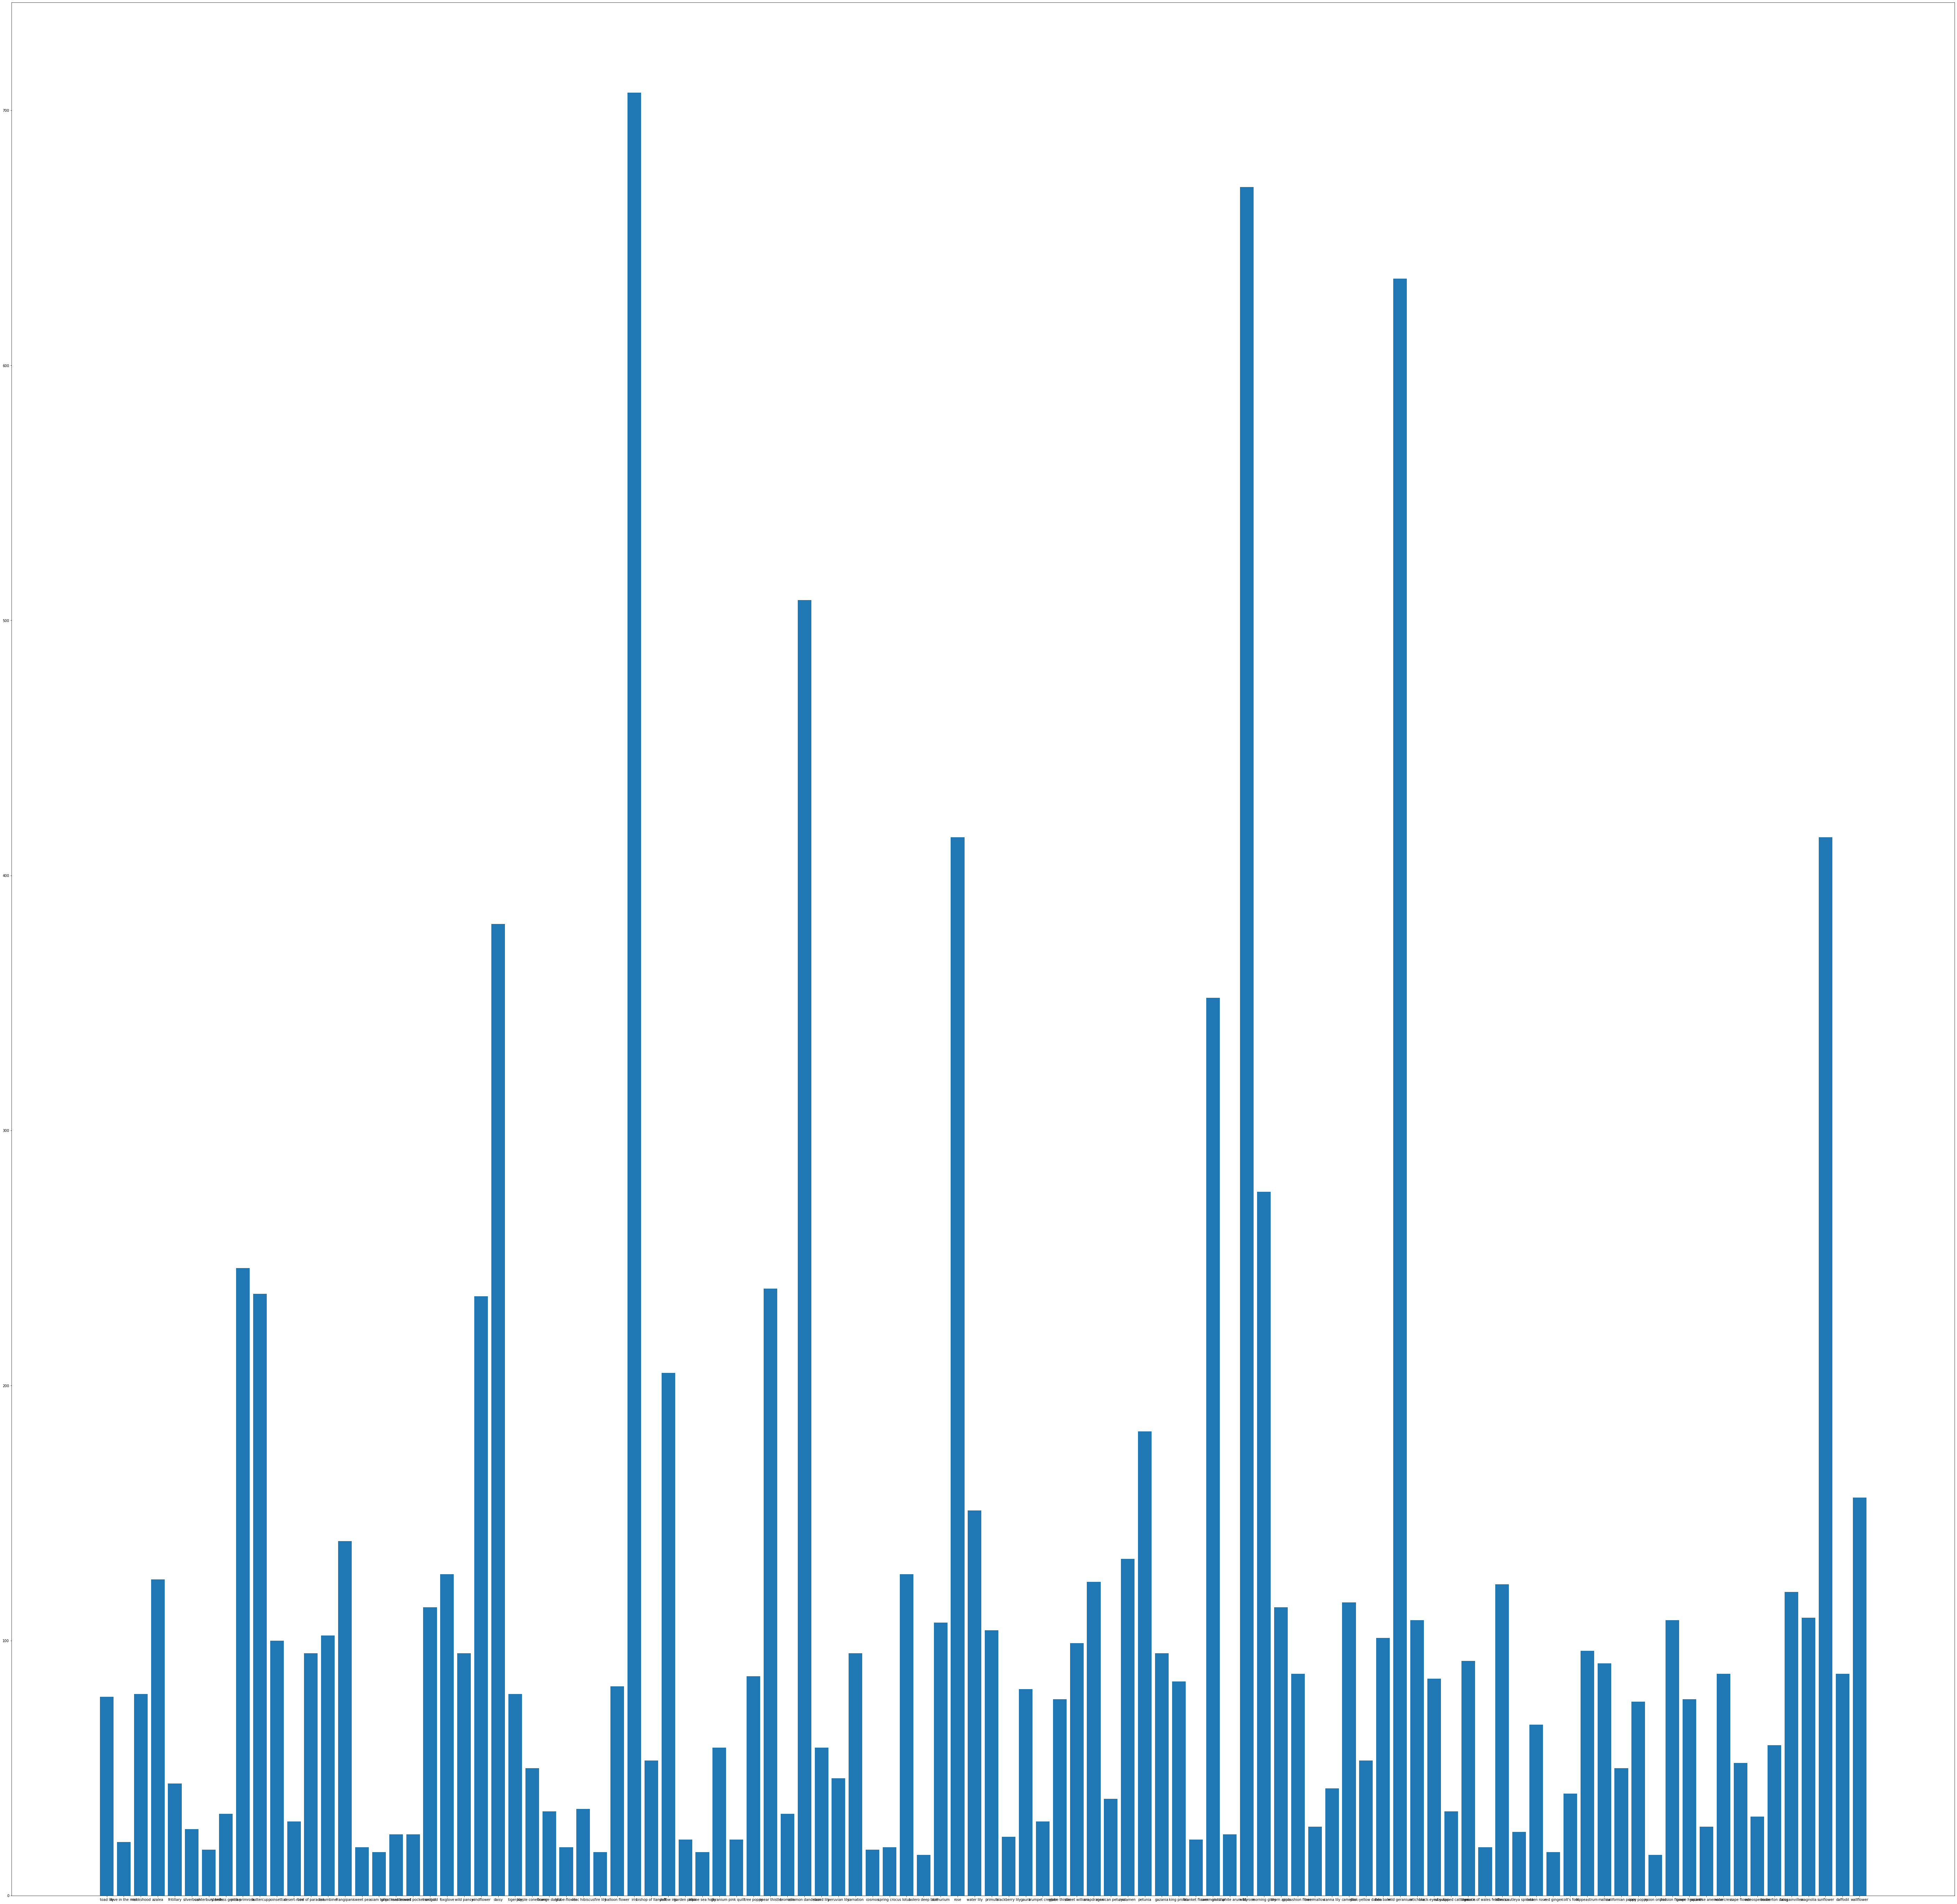

In [145]:
fig, ax = plt.subplots()
plt.figure(figsize=(100, 100))
plt.bar(class_count.keys(), flower_count)

In [149]:
# finding metrics 
class_std = np.std(flower_count)
class_max = max(flower_count)
class_min = min(flower_count)
class_mean = np.mean(flower_count)
class_first_quartile = np.percentile(flower_count, 25)
class_third_quartile = np.percentile(flower_count, 75)
class_tenth_percentile = np.percentile(flower_count, 10)
class_fifth_percentile = np.percentile(flower_count, 5)

print(f'standard deviation: {class_std}')
print(f'max: {class_max}')
print(f'min: {class_min}')
print(f'mean: {class_mean}')
print(f'25%: {class_first_quartile}')
print(f'75%: {class_third_quartile}')
print(f'10%: {class_tenth_percentile}')
print(f'5%: {class_fifth_percentile}')

standard deviation: 132.99130714962862
max: 707
min: 16
mean: 111.1826923076923
25%: 30.5
75%: 113.5
10%: 19.0
5%: 17.15


### going to remove the folders with less than the 10%

In [122]:
# help me gottfried

In [183]:
import shutil
# create new directory if conditions are met
# path of file to copy
# path of file to create a copy

src = 'data/jpeg-192x192/train/toad lily'
dst = 'data/jpeg-192x192/train_new/toad lily'

def copy_subfolder(source):
    destination = src[:23] + '_new' + src[23:]
    
    shutil.copytree(source, destination, symlinks=False, ignore=None, 
                copy_function=shutil.copy2, ignore_dangling_symlinks=False, dirs_exist_ok=False)
    
def item_count(folder):
    file_count = sum(len(files) for _, _, files in os.walk(folder))
    
    return file_count
    
def select_subset(subfolder_list, percentile):
    for subfolder in subfolder_list:
        if item_count(subfolder) < percentile

In [164]:
# get list of all subfolders
def get_directory(something something something):
    for flower in list(class_count.values()):
        print(flower[1])

# print(list(class_count.values())[0][1])

data/jpeg-192x192/train/toad lily
data/jpeg-192x192/train/love in the mist
data/jpeg-192x192/train/monkshood
data/jpeg-192x192/train/azalea
data/jpeg-192x192/train/fritillary
data/jpeg-192x192/train/silverbush
data/jpeg-192x192/train/canterbury bells
data/jpeg-192x192/train/stemless gentian
data/jpeg-192x192/train/pink primrose
data/jpeg-192x192/train/buttercup
data/jpeg-192x192/train/poinsettia
data/jpeg-192x192/train/desert-rose
data/jpeg-192x192/train/bird of paradise
data/jpeg-192x192/train/columbine
data/jpeg-192x192/train/frangipani
data/jpeg-192x192/train/sweet pea
data/jpeg-192x192/train/siam tulip
data/jpeg-192x192/train/great masterwort
data/jpeg-192x192/train/hard-leaved pocket orchid
data/jpeg-192x192/train/marigold
data/jpeg-192x192/train/foxglove
data/jpeg-192x192/train/wild pansy
data/jpeg-192x192/train/windflower
data/jpeg-192x192/train/daisy
data/jpeg-192x192/train/tiger lily
data/jpeg-192x192/train/purple coneflower
data/jpeg-192x192/train/orange dahlia
data/jpeg-192x

## should be the start of preprocessing

### adding everything into actual functions

In [173]:
def get_subfolder_list(source_folder):
    class_list_dir = []

    for file in os.listdir(source_folder):
        d = os.path.join(source_folder, file)
        if os.path.isdir(d):
            class_list_dir.append(d)

    return class_list_dir

In [174]:
def map_classes(subfolder_list):
    class_count = {}

    for class_folder in subfolder_list:
        file_count = sum(len(files) for _, _, files in os.walk(class_folder))
        class_count[class_folder[24:]] = file_count, class_folder
        
    return class_count

In [175]:
def get_flower_count(class_map):
    flower_count = []

    for flower in list(class_count.values()):
        flower_count.append(flower[0])

    return flower_count

In [183]:
# create new directory if conditions are met
# path of file to copy
# path of file to create a copy

src = 'data/jpeg-192x192/train/toad lily'
dst = 'data/jpeg-192x192/train_new/toad lily'

def copy_subfolder(source):
    destination = src[:23] + '_new' + src[23:]
    
    shutil.copytree(source, destination, symlinks=False, ignore=None, 
                copy_function=shutil.copy2, ignore_dangling_symlinks=False, dirs_exist_ok=False)
    
def item_count(folder):
    file_count = sum(len(files) for _, _, files in os.walk(folder))
    
    return file_count
    
def select_subset(subfolder_list, percentile):
    for subfolder in subfolder_list:
        if item_count(subfolder) < percentile

In [182]:
get_subfolder_list(TRAIN_DIR)

['data/jpeg-192x192/train/toad lily',
 'data/jpeg-192x192/train/love in the mist',
 'data/jpeg-192x192/train/monkshood',
 'data/jpeg-192x192/train/azalea',
 'data/jpeg-192x192/train/fritillary',
 'data/jpeg-192x192/train/silverbush',
 'data/jpeg-192x192/train/canterbury bells',
 'data/jpeg-192x192/train/stemless gentian',
 'data/jpeg-192x192/train/pink primrose',
 'data/jpeg-192x192/train/buttercup',
 'data/jpeg-192x192/train/poinsettia',
 'data/jpeg-192x192/train/desert-rose',
 'data/jpeg-192x192/train/bird of paradise',
 'data/jpeg-192x192/train/columbine',
 'data/jpeg-192x192/train/frangipani',
 'data/jpeg-192x192/train/sweet pea',
 'data/jpeg-192x192/train/siam tulip',
 'data/jpeg-192x192/train/great masterwort',
 'data/jpeg-192x192/train/hard-leaved pocket orchid',
 'data/jpeg-192x192/train/marigold',
 'data/jpeg-192x192/train/foxglove',
 'data/jpeg-192x192/train/wild pansy',
 'data/jpeg-192x192/train/windflower',
 'data/jpeg-192x192/train/daisy',
 'data/jpeg-192x192/train/tiger l

### introduce early stopping

### increase batch size and epochs to experiment

In [ ]:
BATCH_SIZE = 128
TRAIN_BATCH_SIZE = BATCH_SIZE
VAL_BATCH_SIZE = BATCH_SIZE
#TEST_BATCH_SIZE = 32

In [ ]:
# Build the model with multiple hidden layers
model_3 = models.Sequential()
model_3.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model_3.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_3.add(layers.Flatten())        
# possibly more layers here
model_3.add(layers.Dense(128))
model_3.add(layers.Activation('relu'))
model_3.add(layers.Dense(NUM_CLASS)) # output layer
model_3.add(layers.Activation('sigmoid'))

In [ ]:
model_3.summary()

In [ ]:
# Define an optimizer, cost lost function, and scoring metric
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_3.fit(train_img, train_lb, epochs=100, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loss, val_acc = model_3.evaluate(val_img, val_lb, batch_size=TRAIN_BATCH_SIZE)

### adding dropout layer

In [ ]:
BATCH_SIZE = 128
TRAIN_BATCH_SIZE = BATCH_SIZE
VAL_BATCH_SIZE = BATCH_SIZE
#TEST_BATCH_SIZE = 32

In [ ]:
# Build the model with multiple hidden layers
model_4 = models.Sequential()
model_4.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model_4.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_4.add(layers.Flatten())        
# possibly more layers here
model_4.add(layers.Dropout(0.2, input_shape=(IMAGE_DIMENSION,)))
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(NUM_CLASS)) # output layer
model_4.add(layers.Activation('sigmoid'))

In [ ]:
model_4.summary()

In [ ]:
# Define an optimizer, cost lost function, and scoring metric
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_4.fit(train_img, train_lb, epochs=100, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loss, val_acc = model_4.evaluate(val_img, val_lb, batch_size=TRAIN_BATCH_SIZE)

### shuffle is turned on. more epochs

In [ ]:
# Build the model with multiple hidden layers
model_1 = models.Sequential()
model_1.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_1.add(layers.Flatten())        
# possibly more layers here
model_1.add(layers.Dense(NUM_CLASS)) # output layer
model_1.add(layers.Activation('sigmoid'))

In [ ]:
model_1.summary()

In [ ]:
# Define an optimizer, cost lost function, and scoring metric
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy'])

In [ ]:
model_1.fit(train_img, train_lb, epochs=150, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loss, val_acc = model_1.evaluate(val_img, val_lb, batch_size=TRAIN_BATCH_SIZE)

### without flattening

In [ ]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[IMAGE_DIMENSION, IMAGE_DIMENSION, 3]
    )
    pretrained_model.trainable = False
    
    model1 = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        # tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])